# Second part of the Capstone Project

In this part, the dataset will be explored and subjected to clustering. In the end, will be generated four datasets for each cluster.

### Importing dataset from the Cloud

#### Loading IBM libraries

In [2]:
import pandas as pd
import ibm_db
import ibm_db_dbi

Magic SQL activated


#### Connecting to server

In [24]:
# The code was removed by Watson Studio for sharing.

'Connected: zcd26955@BLUDB'

In [ ]:
#Create database connection
#DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

try:
    conn = ibm_db.connect(dsn, "", "")
    con = ibm_db_dbi.Connection(conn)
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

#### Downloading dataset

In [35]:
dataframe_filtered = pd.read_sql('select * from DATAFRAME_FILTERED', con)

In [38]:
dataframe_filtered.head()

,index,ID,NAME,LAT,LNG,ADDRESS,CITY,STATE,CATEGORIES
0,0,582670997d7fb761d064e9e9,Sutherland Restaurant Bar and Coffee House,45.443455,-75.670020,224 Beechwood Avenue,Ottawa,ON,Breakfast Spot
1,1,4c0a619d7e3fc928ae70f382,McDonald's,45.441750,-75.643841,594 Montreal Rd.,Ottawa,ON,Fast Food Restaurant
2,2,4ba405edf964a520d07838e3,Pilo's Greek Restaurant,45.446167,-75.630297,876 Montreal Rd,Ottawa Division,ON,Greek Restaurant
3,3,52d71865498e489acd17525d,Le restaurant-école Les Jardins de la Cité,45.439384,-75.627370,"La Cité collégiale, 801",Ottawa,ON,Restaurant
4,4,4b5f23d4f964a5208ea829e3,Navarra,45.429785,-75.693345,93 Murray St.,Ottawa,ON,Spanish Restaurant


#### Separating the gps location for training

In [40]:
data_learn = dataframe_filtered[['LAT','LNG']]
data_learn = data_learn.values #Transforming into Numpy array

#### Loading  libraries for training and visualization

In [41]:
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler

In [42]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [46]:
import numpy as np

In [50]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
print('Folium installed')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Folium installed


In [55]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim  # module to convert an address into latitude and longitude values
print('Geopy installed')
print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geopy                     1.18.1                     py_0    conda-forge
Geopy installed
Libraries imported.


### Training with Scikit Learn

The clustering algorithm chosen was Birtch. 
The Birch builds a tree called the Characteristic Feature Tree (CFT) for the given data. The data is essentially lossy compressed to a set of Characteristic Feature nodes (CF Nodes). The CF Nodes have a number of subclusters called Characteristic Feature subclusters (CF Subclusters) and these CF Subclusters located in the non-terminal CF Nodes can have CF Nodes as children.

In [43]:
brh = Birch(threshold=0.01, branching_factor=50, n_clusters=4, compute_labels=True, copy=False)
brh.fit(data_learn)
labels = brh.predict(data_learn)
labels

#### Setting variables to plot the results

In [52]:
# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# Create colors for the clusters.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

array([[ 0.61960784,  0.00392157,  0.25882353,  1.        ],
       [ 0.99346405,  0.74771242,  0.43529412,  1.        ],
       [ 0.74771242,  0.89803922,  0.62745098,  1.        ],
       [ 0.36862745,  0.30980392,  0.63529412,  1.        ]])

#### Preview plotting with scatter plot

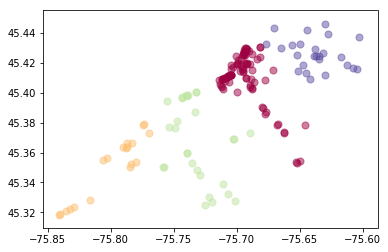

In [53]:
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = data_learn[class_member_mask]
    plt.scatter(xy[:, 1], xy[:, 0],s=50, c=col, marker=u'o', alpha=0.5)

### Plotting the results over Ottawa map

#### Taking Ottawa location

In [73]:
address = '2701 Riverside Dr, Ottawa, ON'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#### Plotting

In [56]:
# Plot the venues within clusters
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the CEF
for k, col in zip(unique_labels, colors):
    cor = "#{0:02x}{1:02x}{2:02x}".format(int(col[0]*255), int(col[1]*255), int(col[2]*255))
    class_member_mask = (labels == k)
    xy = data_learn[class_member_mask]
    for lat, lng in zip(xy[:, 0], xy[:, 1]):
        folium.features.CircleMarker(
            [lat, lng],
            radius=3,
            color= cor,
            popup=str(k),
            fill = True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(cluster_map)
# display map
cluster_map

### Now, is needed to rebuild the dataframe with the clusters and split them.

In [57]:
label = pd.DataFrame({'Cluster':labels}) #Transforming the clusters array into Pandas

In [58]:
label.head()

,Cluster
0,3
1,3
2,3
3,3
4,0


#### Joining the Clusters into the dataframe

In [60]:
data_clustered = pd.concat([dataframe_filtered, label], axis=1)

In [61]:
data_clustered.head()

,index,ID,NAME,LAT,LNG,ADDRESS,CITY,STATE,CATEGORIES,Cluster
0,0,582670997d7fb761d064e9e9,Sutherland Restaurant Bar and Coffee House,45.443455,-75.670020,224 Beechwood Avenue,Ottawa,ON,Breakfast Spot,3
1,1,4c0a619d7e3fc928ae70f382,McDonald's,45.441750,-75.643841,594 Montreal Rd.,Ottawa,ON,Fast Food Restaurant,3
2,2,4ba405edf964a520d07838e3,Pilo's Greek Restaurant,45.446167,-75.630297,876 Montreal Rd,Ottawa Division,ON,Greek Restaurant,3
3,3,52d71865498e489acd17525d,Le restaurant-école Les Jardins de la Cité,45.439384,-75.627370,"La Cité collégiale, 801",Ottawa,ON,Restaurant,3
4,4,4b5f23d4f964a5208ea829e3,Navarra,45.429785,-75.693345,93 Murray St.,Ottawa,ON,Spanish Restaurant,0


#### Building four datsets for each salesperson

In [62]:
group_mask_0 = class_member_mask = (labels == 0)
Cluster_0 = data_clustered[class_member_mask] 

In [63]:
group_mask_1 = class_member_mask = (labels == 1)
Cluster_1 = data_clustered[class_member_mask]

In [64]:
group_mask_2 = class_member_mask = (labels == 2)
Cluster_2 = data_clustered[class_member_mask]

In [65]:
group_mask_3 = class_member_mask = (labels == 3)
Cluster_3 = data_clustered[class_member_mask]

In [66]:
Cluster_0.head()

,index,ID,NAME,LAT,LNG,ADDRESS,CITY,STATE,CATEGORIES,Cluster
4,4,4b5f23d4f964a5208ea829e3,Navarra,45.429785,-75.693345,93 Murray St.,Ottawa,ON,Spanish Restaurant,0
5,5,58c098aa01f43341813efdd0,Sur-Lie,45.429970,-75.692940,"111, Murray Street",Ottawa,ON,French Restaurant,0
6,6,4b5347adf964a520949527e3,Saffron Restaurant,45.430578,-75.681453,426 Rideau St.,Ottawa,ON,Middle Eastern Restaurant,0
7,7,4b9c3786f964a520e95536e3,Sitar Indian Restaurant,45.430496,-75.681453,417 Rideau St.,Ottawa,ON,Indian Restaurant,0
13,13,4c1e0804b4e62d7f0c9bdd93,73 North Restaurant,45.423101,-75.696786,73 Sparks St,Ottawa,ON,Middle Eastern Restaurant,0


In [67]:
Cluster_1.head()

,index,ID,NAME,LAT,LNG,ADDRESS,CITY,STATE,CATEGORIES,Cluster
115,115,4b0da39af964a520e74c23e3,Mugena African Caribbean Foods & Restaurant,45.378573,-75.774348,911 Richmond Rd.,Ottawa,ON,Caribbean Restaurant,1
116,116,4db8c8284df0ded98bc535c7,Ho-Ho Chinese Restaurant,45.379299,-75.773672,875 Richmond Road,Ottawa,ON,Chinese Restaurant,1
123,123,50f1a1e4e4b0d37546f3e928,Carlingwood Family Restaurant,45.366349,-75.783176,"Lincoln Heights, Britannia Bay",Ottawa,ON,Diner,1
124,124,4b62f8c1f964a5208a5b2ae3,Cora's Breakfast & Lunch,45.366697,-75.787195,1355 Richmond Rd,Ottawa,ON,Breakfast Spot,1
125,125,4b65c745f964a52026ff2ae3,Carlingwood Family Restaurant,45.373222,-75.769341,2121 Carling Avenue,Ottawa,ON,Diner,1


In [68]:
Cluster_2.head()

,index,ID,NAME,LAT,LNG,ADDRESS,CITY,STATE,CATEGORIES,Cluster
101,101,522bc6c9498ee49645ff8664,moe's world famous Newport restaurant,45.394624,-75.755414,"322, Churchill Avenue North",Ottawa,ON,Pizza Place,2
102,102,56b65d17498ef040e44a6998,African Village Restaurant,45.398153,-75.739573,1356 Wellington,Ottawa,ON,Ethiopian Restaurant,2
103,103,5455886f498eefcc8498012c,Viet Taste Restaurant,45.398171,-75.740157,1395 Wellington West,Ottawa,ON,Vietnamese Restaurant,2
104,104,5a49aac5b6eedb5d70d32cce,Napoli's Restaurant Pizza & Pasta,45.396812,-75.743123,81 Richmond Rd,Ottawa,ON,Restaurant,2
105,105,4bf3122c94af2d7fa9133972,Napolis Italian Restaurant,45.396936,-75.743153,81 richmond rd,Ottawa,ON,Pizza Place,2


In [69]:
Cluster_3.head()

,index,ID,NAME,LAT,LNG,ADDRESS,CITY,STATE,CATEGORIES,Cluster
0,0,582670997d7fb761d064e9e9,Sutherland Restaurant Bar and Coffee House,45.443455,-75.670020,224 Beechwood Avenue,Ottawa,ON,Breakfast Spot,3
1,1,4c0a619d7e3fc928ae70f382,McDonald's,45.441750,-75.643841,594 Montreal Rd.,Ottawa,ON,Fast Food Restaurant,3
2,2,4ba405edf964a520d07838e3,Pilo's Greek Restaurant,45.446167,-75.630297,876 Montreal Rd,Ottawa Division,ON,Greek Restaurant,3
3,3,52d71865498e489acd17525d,Le restaurant-école Les Jardins de la Cité,45.439384,-75.627370,"La Cité collégiale, 801",Ottawa,ON,Restaurant,3
8,8,4b6f374bf964a520bde42ce3,Habesha,45.432539,-75.676591,574 Rideau St.,Ottawa,ON,Ethiopian Restaurant,3


### Uploading the results to the Cloud

In [77]:
%sql PERSIST Cluster_0
%sql PERSIST Cluster_1
%sql PERSIST Cluster_2
%sql PERSIST Cluster_3
print('Done')

 * ibm_db_sa://zcd26955:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
 * ibm_db_sa://zcd26955:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
 * ibm_db_sa://zcd26955:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
 * ibm_db_sa://zcd26955:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
Done
